# Task 1 - Prepare Dataset for Training

- *Import cuML versions of ML models*
- *Import CuPy, CuDF, and Eval metrics*
- *Load the normalized dataset*
- *Split dataset into Train and Test sets*
- *Define functions to plot Confusion Matrix, ROC and Precision-Recall Curves*

In [1]:
# We use cuML algorithms for fast training

import cuml
from cuml.ensemble import RandomForestClassifier
from cuml.linear_model import LogisticRegression
from cuml.svm import SVC
from cuml.metrics import confusion_matrix
print(cuml.__version__)

24.08.00


In [2]:
# We use cupy arrays instead of numpy arrays to facilitate GPU-accelerated computing with Python

import cupy

In [3]:
# Check CUDA version for nvcc

!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Sep_12_02:18:05_PDT_2024
Cuda compilation tools, release 12.6, V12.6.77
Build cuda_12.6.r12.6/compiler.34841621_0


In [4]:
# We use cudf which accelerates pandas code on the GPU

import cudf

# We still need metrics from scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score

# Import remaining Dependencies
import os
import seaborn as sns
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import time
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [5]:
# First, using cuDF to fetch the normalized data
df = cudf.read_csv('./data/github-normalized-dataset.csv')
df = df.drop(columns=['Unnamed: 0'])
df.head(5)

,Source,Target,Class,Page_Rank_Source,Page_Rank_Target,Shortest_Path,Source_Followers,Source_Following,Target_Followers,Target_Following,Mutual_Followers,Mutual_Following
0,0,23977,1,0.000849,0.002297,0.571429,0.000803,0.000880,0.003479,0.002347,0.0,0.000000
1,1,34526,1,0.000993,0.002706,0.714286,0.001204,0.002054,0.001338,0.001027,0.0,0.000000
2,1,2370,1,0.000993,0.001400,0.571429,0.001204,0.002054,0.001873,0.006895,0.0,0.001548
3,1,14683,1,0.000993,0.004727,0.714286,0.001204,0.002054,0.007225,0.010562,0.0,0.001548
4,1,29982,1,0.000993,0.037747,0.428571,0.001204,0.002054,0.052850,0.015989,0.0,0.000000


In [6]:
# Initialize the Directed Graph from the DataFrame
g = nx.from_pandas_edgelist(df.to_pandas()[['Source', 'Target']], source='Source', target='Target', create_using=nx.DiGraph())

In [7]:
# Prepare X and y for training
df_x = df.drop(columns=['Source', 'Target', 'Class'])  # Drop others and Keep only Features for training
df_y = df[['Class']]  # Labels - Target 

In [8]:
# Using scikit-learn, the dataset is being split into train and test sets, sklearn however needs pandas data
x_train, x_test, y_train, y_test = train_test_split(df_x.to_pandas(), df_y.to_pandas(), test_size=0.3, random_state=42)

# Convert the resulting splits back to cuDF for cuML models
x_train = cudf.DataFrame.from_pandas(x_train)
x_test = cudf.DataFrame.from_pandas(x_test)
y_train = cudf.DataFrame.from_pandas(y_train)
y_test = cudf.DataFrame.from_pandas(y_test)

In [9]:
# Function to plot the ROC curve for a trained model
def plot_roc_curve(actual_labels, predicted_probs, model_name="Model"):
    # Convert cuDF objects to NumPy arrays
    actual_labels = actual_labels.to_pandas().values.ravel()  # Convert to 1D
    predicted_probs = predicted_probs.to_pandas().values.ravel()  # Convert to 1D
    
    # Compute FPR, TPR, and thresholds
    false_positive_rate, true_positive_rate, thresholds_list = roc_curve(actual_labels, predicted_probs)
    auc_score = auc(false_positive_rate, true_positive_rate)

    plt.figure(figsize=(8, 6))
    
    # Plot ROC curve
    plt.plot(false_positive_rate, true_positive_rate, color='#1f77b4', lw=2, 
             label=f'{model_name} (AUC = {auc_score:.2f})')
    
    
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--', lw=2)
    
   
    plt.grid(color='grey', linestyle=':', linewidth=0.5)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    
    
    plt.xlabel('False Positive Rate (FPR)', fontsize=12, fontweight='bold')
    plt.ylabel('True Positive Rate (TPR)', fontsize=12, fontweight='bold')
    plt.title(f'ROC Curve - {model_name}', fontsize=14, fontweight='bold')
    
    
    plt.fill_between(false_positive_rate, true_positive_rate, alpha=0.1, color='blue')
    
    
    annotation_step = max(1, len(thresholds_list) // 8)
    for idx in range(0, len(thresholds_list), annotation_step):
        plt.text(false_positive_rate[idx], true_positive_rate[idx], f"{thresholds_list[idx]:.2f}", fontsize=10, color='black')

    
    plt.legend(loc="lower right", fontsize=10)
    
    plt.show()

In [10]:
# Function to plot the Precision-Recall curve for the models after training
def plot_pr_curve(true_labels, predicted_probs, model_name="Model"):
    # Convert cuDF objects to NumPy arrays
    true_labels = true_labels.to_pandas().values.ravel()  # Convert to 1D
    predicted_probs = predicted_probs.to_pandas().values.ravel()  # Convert to 1D
    
    # Compute Precision-Recall curve and average precision
    precision_vals, recall_vals, threshold_vals = precision_recall_curve(true_labels, predicted_probs)
    avg_precision = average_precision_score(true_labels, predicted_probs)

    plt.figure(figsize=(8, 6))
    
    # Plot Precision-Recall curve
    plt.plot(recall_vals, precision_vals, color='#ff7f0e', lw=2, label=f'{model_name} (Avg Precision = {avg_precision:.2f})')
    
   
    plt.xlabel('Recall', fontsize=12, fontweight='bold')
    plt.ylabel('Precision', fontsize=12, fontweight='bold')
    plt.title(f'Precision-Recall Curve - {model_name}', fontsize=14, fontweight='bold')
    
    
    plt.grid(color='grey', linestyle=':', linewidth=0.5)
    
    plt.fill_between(recall_vals, precision_vals, alpha=0.1, color='orange')
    
    
    plt.legend(loc="lower left", fontsize=10)
    
    plt.show()

In [11]:
def plot_confusion_matrix(y_test, predicted_values, model_name):
    # Ensure y_test and predicted_values are 1D arrays
    y_test_flat = y_test.to_pandas().values.ravel() if hasattr(y_test, 'to_pandas') else y_test.ravel()
    predicted_values_flat = predicted_values.to_pandas().values.ravel() if hasattr(predicted_values, 'to_pandas') else predicted_values.ravel()

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test_flat, predicted_values_flat)

    # Ensure confusion matrix can use GPU or CPU
    C_host = conf_matrix.get() if hasattr(conf_matrix, 'get') else conf_matrix

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        C_host, annot=True, cmap='YlGnBu', fmt='g', linewidths=2, linecolor='black',
        annot_kws={"size": 15, "weight": "bold"}, cbar_kws={'shrink': 0.75}
    )

    plt.xlabel('Predicted Labels', fontsize=14, fontweight='bold', color='darkblue')
    plt.ylabel('True Labels', fontsize=14, fontweight='bold', color='darkblue')
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16, fontweight='bold', color='darkred')

    plt.xticks(fontsize=12, weight='bold', rotation=0, color='darkgreen')
    plt.yticks(fontsize=12, weight='bold', rotation=0, color='darkgreen')

    plt.tight_layout()
    plt.show()

In [12]:
# Function to check if model file exists before training
def model_exists(model_filename):
    return os.path.isfile(model_filename)

# Task 2 - Train, Test, and Visualize Logistic Regression Model

- *Set path for model to be saved*
- *Setup Regularization methods and values*
- *Train and Test all combinations of Regularization methods and values*
- *Save best model and print best parameters and score obtained*
- *Generate Classification Report*
- *Plot Confusion Matrix, ROC curve, and Precision Recall curve*

In [13]:
# Set path for the model file to save or load from
logistic_regression_model_file = './data/github-logistic-regression-model.pkl'

In [14]:
if not model_exists(logistic_regression_model_file):
    print("Initiating Logistic Regression model training...")

    penalty_options = ['l1', 'l2']  # Regularization methods: Lasso, Ridge
    regularization_values = np.logspace(0, 4, 10)  # Regularization strengths

    # Initialize placeholders for the best model parameters and score
    optimal_params = None
    optimal_model = None
    highest_score = -1

    start_time = time.time()

    # Training loop for different penalty methods and C values
    for reg_penalty in penalty_options:
        for reg_strength in regularization_values:
            lr_model = LogisticRegression(penalty=reg_penalty, C=reg_strength)
            lr_model.fit(x_train, y_train)
            test_score = lr_model.score(x_test, y_test)

            if test_score > highest_score:
                highest_score = test_score
                optimal_params = {'penalty': reg_penalty, 'C': reg_strength}
                optimal_model = lr_model

    end_time = time.time()
    print('Time taken for Logistic Regression training:', round(end_time - start_time, 2), 'seconds')
    print('Optimal parameters identified:', optimal_params)
    print('Highest accuracy score:', highest_score)

    # save it
    pickle.dump(optimal_model, open(logistic_regression_model_file, 'wb'))
else:
    print("Logistic Regression model already exists. Loading model from file.")
    optimal_model = pickle.load(open(logistic_regression_model_file, 'rb'))  # Load the previously saved model if exitss

Initiating Logistic Regression model training...
Time taken for Logistic Regression training: 3.96 seconds
Optimal parameters identified: {'penalty': 'l1', 'C': 1.0}
Highest accuracy score: 0.8675909042358398


In [15]:
# Generate predictions and classification report for Logistic Regression
predicted_values = optimal_model.predict(x_test)
print(classification_report(y_test.to_pandas(), predicted_values.to_pandas()))

              precision    recall  f1-score   support

           0       0.83      0.92      0.87     86926
           1       0.91      0.81      0.86     86476

    accuracy                           0.87    173402
   macro avg       0.87      0.87      0.87    173402
weighted avg       0.87      0.87      0.87    173402



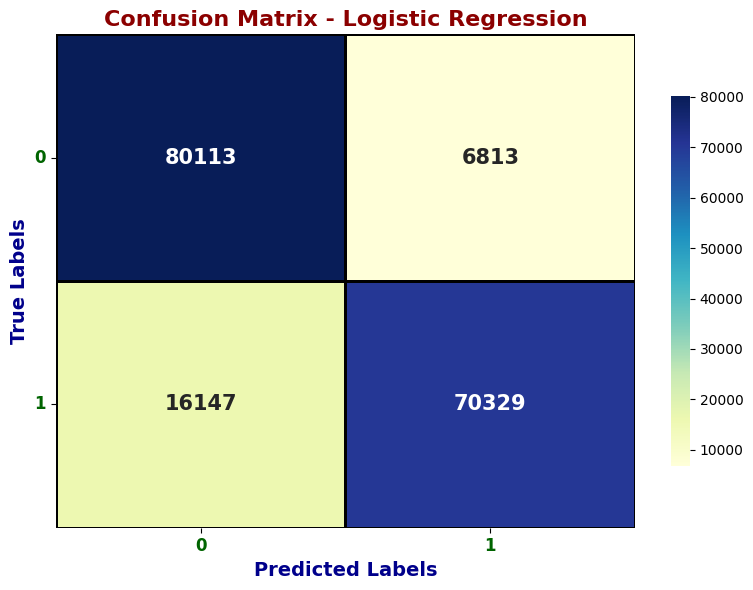

In [16]:
plot_confusion_matrix(y_test, predicted_values, "Logistic Regression")

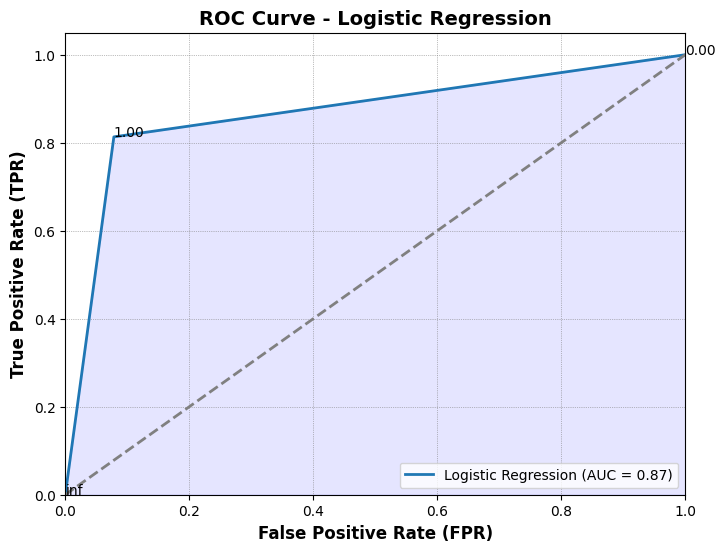

In [17]:
#Receiver Operating Characteristic Curve Plot
plot_roc_curve(y_test, predicted_values, model_name="Logistic Regression")

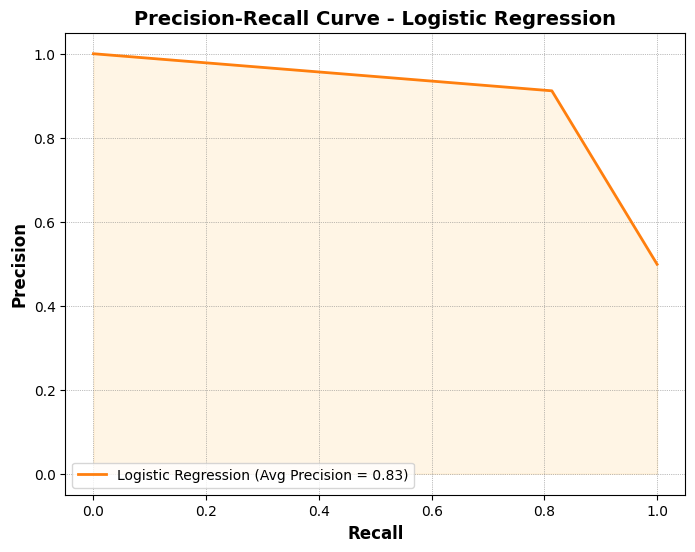

In [18]:
#Precision-Recall Curve Plot
plot_pr_curve(y_test, predicted_values, model_name="Logistic Regression")

# Task 3 - Train, Test, and Visualize Random Forest Model

- *Set path for model to be saved*
- *Setup ranges for trees, depths, splits, and leaves*
- *Train and Test all combinations of Parameters*
- *Save best model and print best parameters and score obtained*
- *Generate Classification Report*
- *Plot Confusion Matrix, ROC curve, and Precision Recall curve*

In [19]:
random_forest_model_file = './data/github-random-forest-model.pkl'

In [20]:
if not model_exists(random_forest_model_file):
    print("Training Random Forest model...")

    # Convert y_train to 1D for compatibility
    y_train_flat = y_train.to_pandas().values.ravel()
    y_test_flat = y_test.to_pandas().values.ravel()

    # Define parameters
    num_trees = [50, 100, 150]  # Number of trees in the forest
    max_tree_depths = [9, 12, 15, 24]  # Maximum depth of trees
    min_samples_splits = np.random.randint(100, 150, 2)  # Min samples required to split a node
    min_samples_leaves = np.random.randint(20, 30, 2)  # Min samples required at a leaf node

    best_params = None
    best_model = None
    best_score = -1

    start_time = time.time()

    for trees in num_trees:
        for depth in max_tree_depths:
            for split in min_samples_splits:
                for leaf in min_samples_leaves:
                    
                    # train Random Forest model
                    rf_model = RandomForestClassifier(n_estimators=trees, max_depth=depth, 
                                                      min_samples_split=split, min_samples_leaf=leaf)
                    rf_model.fit(x_train, y_train_flat)

                    accuracy = rf_model.score(x_test, y_test_flat)

                # Store best model parameters
                    if accuracy > best_score:
                        best_score = accuracy
                        best_params = {
                            'n_estimators': trees,
                            'max_depth': depth,
                            'min_samples_split': split,
                            'min_samples_leaf': leaf
                        }
                        best_model = rf_model

    end_time = time.time()
    print('Time taken to train Random Forest model:', round(end_time - start_time, 2), 'seconds')
    print('Best parameters found:', best_params)
    print('Best accuracy score:', best_score)

    # Save the best model to a file
    pickle.dump(best_model, open(random_forest_model_file, 'wb'))

else:
    print("Random Forest model already exists. Loading from file.")
    best_model = pickle.load(open(random_forest_model_file, 'rb'))  # Load the existing model


Training Random Forest model...
Time taken to train Random Forest model: 37.44 seconds
Best parameters found: {'n_estimators': 50, 'max_depth': 24, 'min_samples_split': 121, 'min_samples_leaf': 20}
Best accuracy score: 0.8813854455947876


In [21]:
# Predictions and classification report for Random Forest
predicted_values = best_model.predict(x_test)
print(classification_report(y_test.to_pandas(), predicted_values.to_pandas()))

              precision    recall  f1-score   support

           0       0.86      0.91      0.88     86926
           1       0.90      0.86      0.88     86476

    accuracy                           0.88    173402
   macro avg       0.88      0.88      0.88    173402
weighted avg       0.88      0.88      0.88    173402



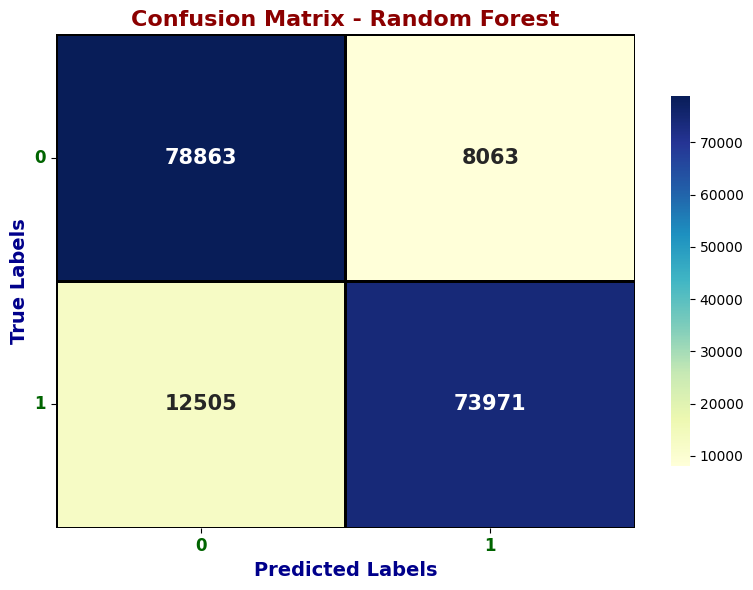

In [22]:
plot_confusion_matrix(y_test, predicted_values, "Random Forest")

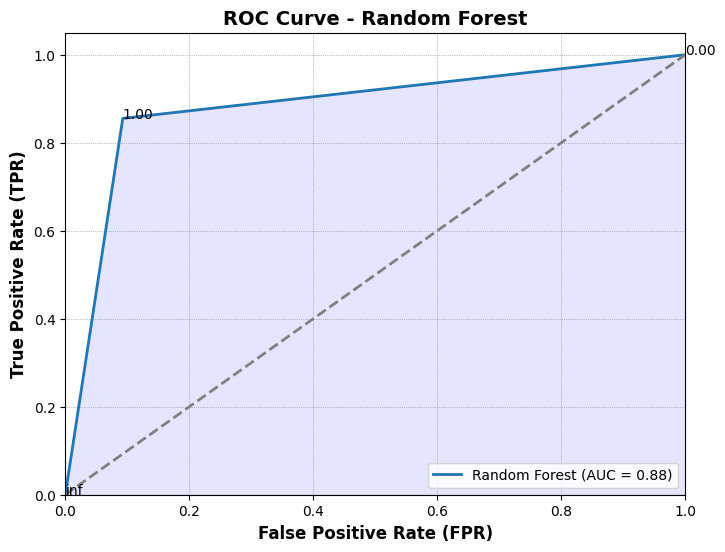

In [23]:
plot_roc_curve(y_test, predicted_values, model_name="Random Forest")

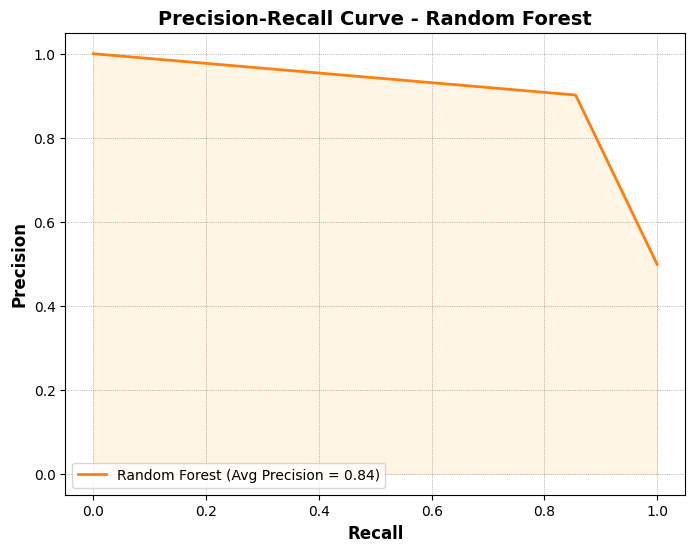

In [24]:
plot_pr_curve(y_test, predicted_values, model_name="Random Forest")

# Task 4 - Train, Test, and Visualize Support Vector Machine Model

- *Set path for model to be saved*
- *Setup kernels and range of regularization values*
- *Train and Test all combinations of hyperparameters*
- *Save best model and print best parameters and score obtained*
- *Generate Classification Report*
- *Plot Confusion Matrix, ROC curve, and Precision Recall curve*

In [25]:
# Model Path
svm_model_file = './data/github-support-vector-machine-model.pkl'

In [26]:
if not model_exists(svm_model_file):
    print("Training Support Vector Machine (SVM) model...")

    # Define hyperparameters
    kernel_types = ['rbf', 'linear']  # Types of SVM kernels for mapping data
    regularization_values = [0.001, 0.01, 0.1, 1]  # Regularization values

    best_params = None
    best_model = None
    best_accuracy = -1

    start_time = time.time()

    for kernel in kernel_types:
        for regularization in regularization_values:
            svm_model = SVC(kernel=kernel, C=regularization)
            svm_model.fit(x_train, y_train)
            accuracy = svm_model.score(x_test, y_test)


            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {'kernel': kernel, 'C': regularization}
                best_model = svm_model

    end_time = time.time()
    print('Time taken to train SVM model:', round(end_time - start_time, 2), 'seconds')
    print('Best parameters:', best_params)
    print('Best accuracy score:', best_accuracy)

    pickle.dump(best_model, open(svm_model_file, 'wb'))

else:
    print("SVM model already exists. Loading from file.")  # Load the saved model if it exists
    best_model = pickle.load(open(svm_model_file, 'rb'))
    

Training Support Vector Machine (SVM) model...
[W] [10:47:05.588263] SVC with the linear kernel can be much faster using the specialized solver provided by LinearSVC. Consider switching to LinearSVC if tranining takes too long.
Time taken to train SVM model: 152.67 seconds
Best parameters: {'kernel': 'linear', 'C': 1}
Best accuracy score: 0.8578909039497375


In [27]:
# Classification report for SVM
predicted_values = best_model.predict(x_test)
print(classification_report(y_test.to_pandas(), predicted_values.to_pandas()))

              precision    recall  f1-score   support

           0       0.82      0.91      0.87     86926
           1       0.90      0.80      0.85     86476

    accuracy                           0.86    173402
   macro avg       0.86      0.86      0.86    173402
weighted avg       0.86      0.86      0.86    173402



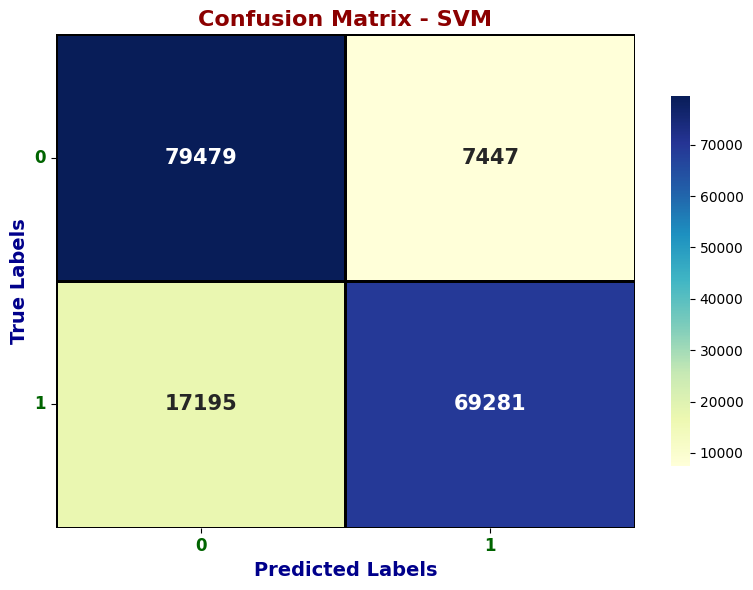

In [28]:
plot_confusion_matrix(y_test, predicted_values, "SVM")

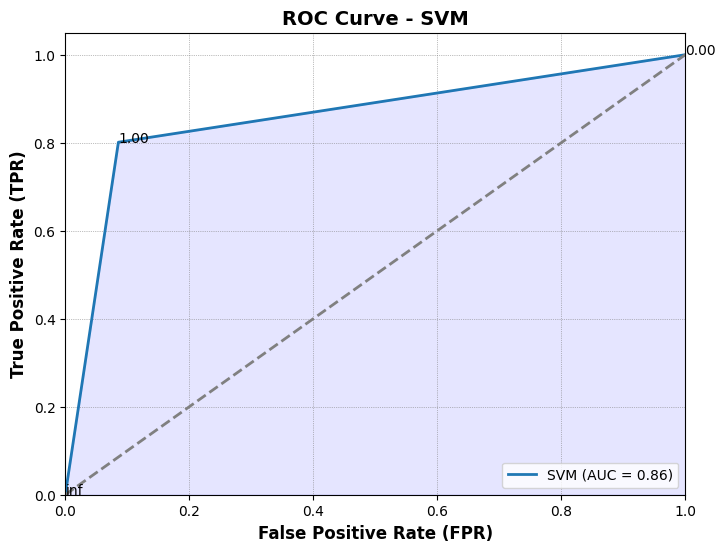

In [29]:
#Receiver Operating Characteristic Curve Plot
plot_roc_curve(y_test, predicted_values, model_name="SVM")

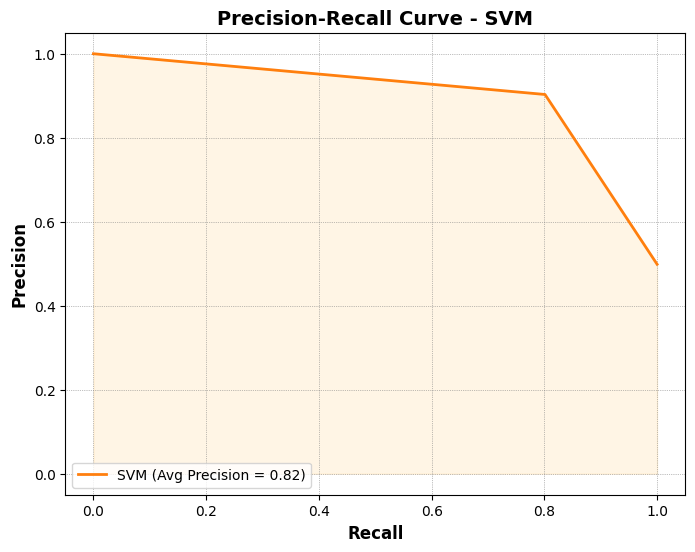

In [30]:
#Precision-Recall Curve Plot
plot_pr_curve(y_test, predicted_values, model_name="SVM")